In [2]:
import os
import sys
import yaml
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf

def get_all_labels(input_yaml, riib=False):
    """ Gets all labels within label file
    Note that RGB images are 1280x720 and RIIB images are 1280x736.
    :param input_yaml: Path to yaml file
    :param riib: If True, change path to labeled pictures
    :return: images: Labels for traffic lights
    """
    images = yaml.load(open(input_yaml, 'rb').read())

    for i in range(len(images)):
        images[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(input_yaml), images[i]['path']))
        if riib:
            images[i]['path'] = images[i]['path'].replace('.png', '.pgm')
            images[i]['path'] = images[i]['path'].replace('rgb/train', 'riib/train')
            images[i]['path'] = images[i]['path'].replace('rgb/test', 'riib/test')
            for box in images[i]['boxes']:
                box['y_max'] = box['y_max'] + 8
                box['y_min'] = box['y_min'] + 8
    return images

In [3]:
PATH_TO_DATA = '/home/sebastian/Udacity/SDC-System-Integration/classifier/data'
images = get_all_labels(PATH_TO_DATA + '/train.yaml')

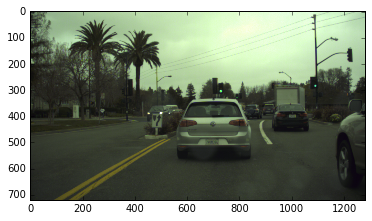

(1280, 720)

In [4]:
image = Image.open(images[100]['path'])
plt.imshow(image)
plt.show()
image.size

In [5]:
for box in images[100]['boxes']:
    print box

{'y_min': 277.5, 'x_max': 737.125, 'occluded': False, 'x_min': 717.75, 'y_max': 314.75, 'label': 'Green'}
{'y_min': 316.5, 'x_max': 796.0, 'occluded': False, 'x_min': 783.125, 'y_max': 337.25, 'label': 'Green'}
{'y_min': 261.25, 'x_max': 1095.375, 'occluded': False, 'x_min': 1081.875, 'y_max': 295.125, 'label': 'Green'}
{'y_min': 276.0, 'x_max': 931.5, 'occluded': False, 'x_min': 921.75, 'y_max': 296.5, 'label': 'Red'}
{'y_min': 146.125, 'x_max': 1229.25, 'occluded': False, 'x_min': 1208.375, 'y_max': 196.375, 'label': 'off'}
{'y_min': 315.625, 'x_max': 806.875, 'occluded': False, 'x_min': 797.375, 'y_max': 334.125, 'label': 'Red'}


In [6]:
import sys

# This is needed to display the images.
%matplotlib inline

sys.path.append("/home/sebastian/Udacity/SDC-System-Integration/classifier/models") # point to your tensorflow dir
sys.path.append("/home/sebastian/Udacity/SDC-System-Integration/classifier/models/slim")
sys.path.append("/home/sebastian/Udacity/SDC-System-Integration/classifier/models/object_detection/")

In [26]:
from object_detection.utils import dataset_util


def create_tf_example(example):
    # TODO(user): Populate the following variables from your example.
    height = 720 # Image height
    width = 1280 # Image width
    filename = example['path'] # Filename of the image. Empty if image is not from file

    #### porblem area
    encoded_image_data =bytearray(open(filename, "r").read())

    
    #####
    
    image_format = b'png' # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    for box in example['boxes']:
        if box['occluded']:
            continue
        else:
            xmins.append(box['x_min']/width)
            xmaxs.append(box['x_max']/width)
            ymins.append(box['y_min']/height)
            ymaxs.append(box['y_max']/height)
            classes_text.append(box['label'])
            classes.append(1)

    print 'done'

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


In [27]:
create_tf_example(images[100])

/home/sebastian/Udacity/SDC-System-Integration/classifier/data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/212540.png
done


TypeError: bytearray(b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05\x00\x00\x00\x02\xd0\x08\x02\x00\x00\x00@ has type bytearray, but expected one of: bytes

In [28]:
encoded_image_data = open('/home/sebastian/Udacity/SDC-System-Integration/classifier/data/rgb/train/2017-02-03-11-44-56_los_altos_mountain_view_traffic_lights_bag/212540.png', "rb").read()


'\r'